# Importing Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,re,h5py
import time
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten,Conv2D,MaxPooling2D, Dropout,BatchNormalization,ZeroPadding2D,Concatenate,Input
from keras.models import Model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/Malaria_Cell_Dataset"
METRICS_PATH="/content/drive/MyDrive/Metrics/Malaria_Cell_Metrics/"
MODEL_NAME="RCCNet"
print("PWD", PATH)

PWD /content/drive/MyDrive/Malaria_Cell_Dataset


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['Parasitized', 'Uninfected']


In [ ]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        img_data_list.append(x)


Loaded the images of dataset-Parasitized

Loaded the images of dataset-Uninfected



In [ ]:
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(27558, 1, 32, 32, 3)
(1, 27558, 32, 32, 3)
(27558, 32, 32, 3)


# Train and Test Data

In [ ]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:13780] = 1
labels[13780:] = 0
names = ['Parasitized', 'Uninfected']

sample 27558


In [ ]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                      

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Model Training

### With Augumentation

In [ ]:
batch_size =16
data_augmentation = True
epochs = 100 

In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Using real-time data augmentation.
Epoch 1/100


<ipython-input-26-14e19c93b40b>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


1378/1378 [==============================] - 24s 16ms/step - loss: 0.5419 - accuracy: 0.7542 - f1: 0.7542 - specificity: 0.7542 - sensitivity: 0.7542 - val_loss: 0.4334 - val_accuracy: 0.8082 - val_f1: 0.8074 - val_specificity: 0.8074 - val_sensitivity: 0.8074 - lr: 6.0000e-05
Epoch 2/100
1378/1378 [==============================] - 20s 14ms/step - loss: 0.3531 - accuracy: 0.8586 - f1: 0.8586 - specificity: 0.8586 - sensitivity: 0.8586 - val_loss: 0.2143 - val_accuracy: 0.9185 - val_f1: 0.9178 - val_specificity: 0.9178 - val_sensitivity: 0.9178 - lr: 6.0000e-05
Epoch 3/100
1378/1378 [==============================] - 20s 14ms/step - loss: 0.2664 - accuracy: 0.8987 - f1: 0.8987 - specificity: 0.8987 - sensitivity: 0.8987 - val_loss: 0.1728 - val_accuracy: 0.9376 - val_f1: 0.9379 - val_specificity: 0.9379 - val_sensitivity: 0.9379 - lr: 6.0000e-05
Epoch 4/100
1378/1378 [==============================] - 20s 14ms/step - loss: 0.2346 - accuracy: 0.9131 - f1: 0.9131 - specificity: 0.9131 - 

In [ ]:
  print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 2193.3709754943848
173/173 [==============================] - 1s 4ms/step - loss: 0.1052 - accuracy: 0.9653 - f1: 0.9655 - specificity: 0.9655 - sensitivity: 0.9655
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.5418933629989624, 0.35311052203178406, 0.26637497544288635, 0.23462910950183868, 0.2059318721294403, 0.18885628879070282, 0.18578116595745087, 0.177006796002388, 0.17200127243995667, 0.16459986567497253, 0.15633104741573334, 0.15202346444129944, 0.15214481949806213, 0.153572216629982, 0.14329710602760315, 0.14161339402198792, 0.14280347526073456, 0.14344708621501923, 0.13793563842773438, 0.13964301347732544, 0.13504445552825928, 0.13277530670166016, 0.1322304606437683, 0.1307116597890854, 0.13061650097370148, 0.12300917506217957, 0.12611986696720123, 0.12229901552200317, 0.12204279005527496, 0.12066293507814407, 0.1215408

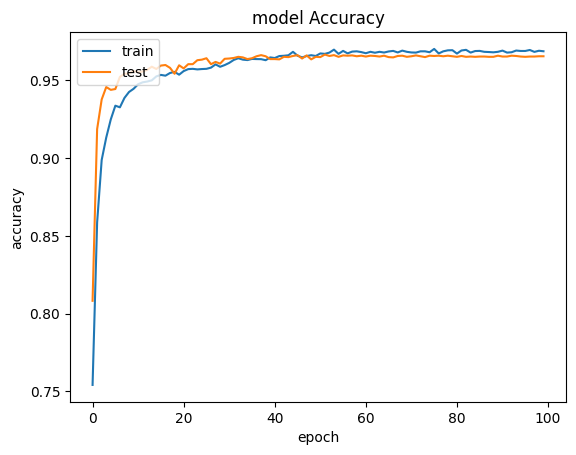

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

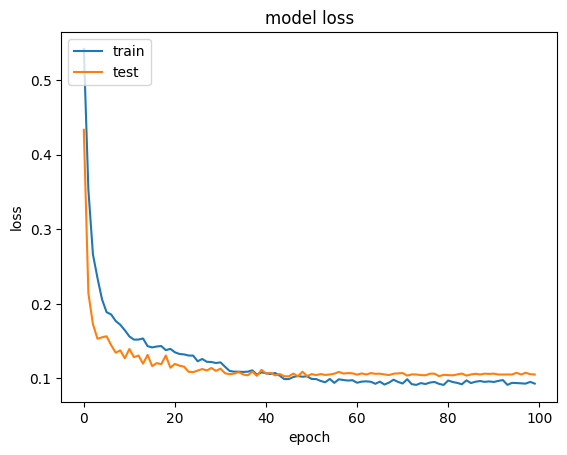

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


### Without Augumentation

In [ ]:
MODEL_NAME="RCCNet_waug"

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                      

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
batch_size =16
data_augmentation = False
epochs = 100 

In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Not using data augmentation.
Epoch 1/100
1378/1378 [==============================] - 13s 8ms/step - loss: 0.5095 - accuracy: 0.7750 - f1: 0.7750 - specificity: 0.7750 - sensitivity: 0.7750 - val_loss: 0.3357 - val_accuracy: 0.8627 - val_f1: 0.8623 - val_specificity: 0.8623 - val_sensitivity: 0.8623 - lr: 6.0000e-05
Epoch 2/100
1378/1378 [==============================] - 11s 8ms/step - loss: 0.2907 - accuracy: 0.8857 - f1: 0.8857 - specificity: 0.8857 - sensitivity: 0.8857 - val_loss: 0.2543 - val_accuracy: 0.9038 - val_f1: 0.9038 - val_specificity: 0.9038 - val_sensitivity: 0.9038 - lr: 6.0000e-05
Epoch 3/100
1378/1378 [==============================] - 11s 8ms/step - loss: 0.2151 - accuracy: 0.9193 - f1: 0.9192 - specificity: 0.9192 - sensitivity: 0.9192 - val_loss: 0.1775 - val_accuracy: 0.9343 - val_f1: 0.9344 - val_specificity: 0.9344 - val_sensitivity: 0.9344 - lr: 6.0000e-05
Epoch 4/100
1378/1378 [==============================] - 12s 9ms/step - loss: 0.1857 - accuracy: 0.9342 

In [ ]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 1217.175106048584
173/173 [==============================] - 1s 7ms/step - loss: 0.2175 - accuracy: 0.9478 - f1: 0.9480 - specificity: 0.9480 - sensitivity: 0.9480
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.5094509124755859, 0.29073023796081543, 0.21514591574668884, 0.18571129441261292, 0.1582847237586975, 0.14223887026309967, 0.1323242336511612, 0.1221107468008995, 0.11120082437992096, 0.09788451343774796, 0.08665557950735092, 0.06924913823604584, 0.059687063097953796, 0.0541868582367897, 0.05176008120179176, 0.04564055800437927, 0.04354163631796837, 0.036896996200084686, 0.0346817821264267, 0.03675060719251633, 0.031004134565591812, 0.03082418255507946, 0.031391557306051254, 0.026900913566350937, 0.02858082391321659, 0.024675605818629265, 0.029002714902162552, 0.02653375454246998, 0.02669106423854828, 0.025131087750196457, 

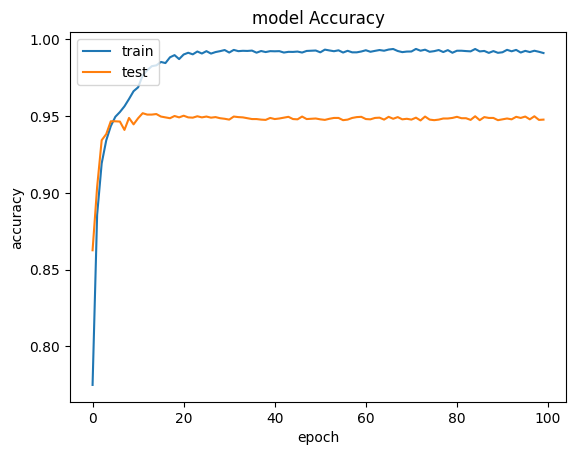

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

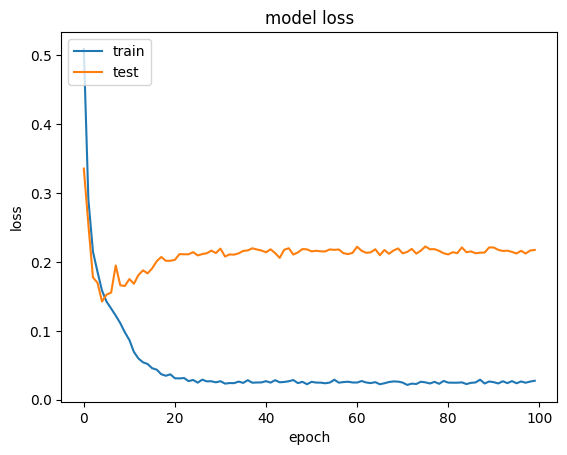

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
